In [1]:
# Importando as bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time

In [2]:
# Inicializando o driver com as configurações do Google Chrome

service = Service()

options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=service, options=options)

In [3]:
# Passando o url do CNES e acessando com o Chrome

url = "https://cnes.datasus.gov.br/"

driver.get(url)

In [4]:
# Variáveis para busca (Usaremos o município de Caratinga - MG para esse exemplo)
estado = "Minas Gerais".upper()
municipio = "Caratinga".upper() 
natureza_juridica = "Administração Pública".upper()

#Variável de tempo de espera padrão
wait = WebDriverWait(driver, 10)

#Variável de tempo de espera listagem profisionais
wait_profissionais = WebDriverWait(driver, 1.5)

In [5]:
# Selecionando o input de estabelecimento de saúde, preenchendo um nome e pressionando enter

input_estabelecimento = driver.find_element(By.ID, "nomePesqEstab")

input_estabelecimento.send_keys("joao")

input_estabelecimento.send_keys(Keys.ENTER)

In [6]:
# Limpando o campo de pesquisa

input_pesquisa = driver.find_element(By.ID, "pesquisaValue")

input_pesquisa.clear()

In [7]:
# Seleciona o estado Escolhido

time.sleep(1)

select_estado = Select(driver.find_element(By.CSS_SELECTOR, "body > div.layout > main > div > div.col-md-12.ng-scope > div > form:nth-child(4) > div:nth-child(2) > div:nth-child(1) > div > select"))

select_estado.select_by_visible_text(estado)

In [8]:
# Seleciona o Município escolhido

time.sleep(1)

select_municipio = Select(driver.find_element(By.CSS_SELECTOR, "body > div.layout > main > div > div.col-md-12.ng-scope > div > form.form-inline.ng-valid.ng-dirty.ng-valid-parse > div:nth-child(2) > div:nth-child(2) > div > select"))

wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "body > div.layout > main > div > div.col-md-12.ng-scope > div > form.form-inline.ng-valid.ng-dirty.ng-valid-parse > div:nth-child(2) > div:nth-child(2) > div > select")))

select_municipio.select_by_visible_text(municipio)


In [9]:
# Seleciona a Natureza Juridica

select_natureza_juridica = Select(driver.find_element(By.CSS_SELECTOR, "body > div.layout > main > div > div.col-md-12.ng-scope > div > form:nth-child(4) > div:nth-child(3) > div.col-md-7 > div > select"))

select_natureza_juridica.select_by_visible_text(natureza_juridica)

In [10]:
# Aguarda o botão ficar disponivel para clique e confirma a busca

time.sleep(1)

wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "btn-primary")))

button_pesquisa = driver.find_element(By.CLASS_NAME, "btn-primary")

button_pesquisa.click()

In [11]:
# Função que coleta o link das unidades e armazena cada um no array

list_url = []

def get_url_estabelecimento(ficha_estabelecimentos):
    for ficha in ficha_estabelecimentos:
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "a.btn.btn-default[title='Ficha estabelecimento']")))
        url_estabelecimento = ficha.get_attribute("href")
        list_url.append(url_estabelecimento)
        

In [12]:
# Laço que executa a função anterior e pula para proxima página até chegar na última

time.sleep(1)

while True:
    try:
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.btn.btn-default[title='Ficha estabelecimento']")))
        ficha_estabelecimentos = driver.find_elements(By.CSS_SELECTOR, "a.btn.btn-default[title='Ficha estabelecimento']")
        get_url_estabelecimento(ficha_estabelecimentos)

        wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'li.ng-scope > a.ng-scope[ng-switch-when="next"]')))
        button_state = driver.find_elements(By.CSS_SELECTOR, "li")[-1].get_attribute("class")
        next_button = driver.find_element(By.CSS_SELECTOR, 'li.ng-scope > a.ng-scope[ng-switch-when="next"]')
        next_button.click()
    
        if button_state == "ng-scope disabled": # Se o botão usado para avançar para próxima página estiver desabilitado, pare o laço
            break
    except TimeoutException:
        print("Tempo de espera excedido. Verifique a velocidade da página ou ajuste o tempo de espera.")
        break


In [13]:
# Entrando na tela de profissionais e coletando todas as informações que precisamos, pulando páginas na listagem caso seja preciso.

list_ubs_cnes = []
list_prof_ubs = []
list_prof_name = []
list_prof_cns = []
list_prof_cbo = []

for url in list_url:
    driver.get(url) # Entra em cada estabelecimento pela url que coletamos anteriormente

    wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#estabContent > aside > section > ul > li:nth-child(6) > a"))) # Aguarda o módulo profissionais ficar disponível para clique

    driver.find_element(By.CSS_SELECTOR, "#estabContent > aside > section > ul > li:nth-child(6) > a").click()

    while True:
        
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#estabContent > div > section > div:nth-child(3) > div > div.box-body > div.col-lg-12.col-xs-12.ng-scope"))) # Aguarda a div da listagem ficar disponível
        
        try:            
            wait_profissionais.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'td[data-title-text="Nome"]')))
            

            profissional_ubs = driver.find_element(By.CSS_SELECTOR, 'input.form-control.input-sm[ng-value="estabelecimento.noFantasia"]')
            profissional_cnes = driver.find_element(By.CSS_SELECTOR, 'input.form-control.input-sm[ng-value="estabelecimento.cnes"]')

            profissional_nomes = driver.find_elements(By.CSS_SELECTOR, 'td[data-title-text="Nome"]')
            profissional_cns = driver.find_elements(By.CSS_SELECTOR, 'td[data-title-text="CNS"]')
            profissional_cbo = driver.find_elements(By.CSS_SELECTOR, 'td[data-title-text="Descrição"]')

            for cnes in profissional_cbo:
                list_ubs_cnes.append(profissional_cnes.get_property("value")) 

            for ubs in profissional_cbo:
                list_prof_ubs.append(profissional_ubs.get_property("value"))

            for nome in profissional_nomes:
                list_prof_name.append(nome.text)

            for cns in profissional_cns:
                list_prof_cns.append(cns.text)

            for cbo in profissional_cbo:
                list_prof_cbo.append(cbo.text)
        except:
            nome_ubs = driver.find_element(By.CSS_SELECTOR, 'input.form-control.input-sm[ng-value="estabelecimento.noFantasia"]').get_property("value")
            print(f"Nenhum resultado para unidade: {nome_ubs}") 
            pass 
        try:
            button_state = driver.find_elements(By.CSS_SELECTOR, "li")[-1].get_attribute("class")
            next_button = driver.find_element(By.CSS_SELECTOR, 'li.ng-scope > a.ng-scope[ng-switch-when="next"]')
            next_button.click()
    
            if button_state == "ng-scope disabled":
                break
        except:
            break

Nenhum resultado para unidade: ESF ANAPOLIS II
Nenhum resultado para unidade: ESF BAIRRO SANTA CRUZ I
Nenhum resultado para unidade: ESF FLORESTA
Nenhum resultado para unidade: ESF SANTA ZITA II
Nenhum resultado para unidade: PAM UNIDADE II
Nenhum resultado para unidade: POSTO DE SAUDE DE DOM MODESTO


In [14]:
# Fechando o driver

driver.close()

In [15]:
# Criando um DataFrame com os dados

df_cnes = pd.DataFrame({
    "cnes": list_ubs_cnes,
    "unidade": list_prof_ubs,
    "nome": list_prof_name,
    "cns": list_prof_cns,
    "cbo": list_prof_cbo
    })

display(df_cnes)

,cnes,unidade,nome,cns,cbo
0,7983778,ACADEMIA DA SAUDE OTAVIO CIRYLLIO FERREIRA,JESSICA GOULART HUDSON,700205427164629,PROFISSIONAL DE EDUCACAO FISICA NA SAUDE
1,7333269,AGENCIA PRISIONAL DE CARATINGA MG,IGOR DE OLIVEIRA CLABER SIQUEIRA,706402605006387,MEDICO CLINICO
2,6913857,CAPS ALCOOL E DROGAS,ANAEGE ALVES DE PAULA,705009650580250,FAXINEIRO
3,6913857,CAPS ALCOOL E DROGAS,ANDREIA MOL ALVES,706308155835880,PSICOLOGO CLINICO
4,6913857,CAPS ALCOOL E DROGAS,BRUNO RAMOS ALBANO,704005346802867,ENFERMEIRO
...,...,...,...,...,...
758,0603112,USB SAMU CARATINGA,GERALDO ANTONIO DE SOUSA JUNIOR,700807904858085,CONDUTOR DE AMBULANCIA
759,0603112,USB SAMU CARATINGA,GILSON ERNESTINO DO CARMO ROCHA,700001945877205,CONDUTOR DE AMBULANCIA
760,0603112,USB SAMU CARATINGA,MARINA REIS DE SOUZA,704008338968762,TECNICO DE ENFERMAGEM
761,0603112,USB SAMU CARATINGA,SABRINA GARCIA DA SILVA,705406433767496,TECNICO DE ENFERMAGEM


In [16]:
# Armazenando os dados do DataFrame em um arquivo xlsx para ser visualizado mais tarde no Exel

df_cnes.to_excel("cnes.xlsx", index=False)

## Manipulação e Visualização dos dados

##### Descobrindo a quantidade ACS e ACE  em cada unidade para uma melhora na distribuição de recursos

In [17]:
# Aqui estamos criando duas colunas a partir de uma cópia do DataFrame original. 

df_agentes = df_cnes.copy() # Criando uma cópia do DataFrame original

# Se o profissional for ACS ou ACE, retorna 1 (Sim), caso possua outro CBO irá retornar 0 (Não)
df_agentes['ACS'] = (df_agentes['cbo'] == 'AGENTE COMUNITARIO DE SAUDE').astype(int) # Criando a coluna 'ACS' no formato boleano e convertendo para inteiro
df_agentes['ACE'] = (df_agentes['cbo'] == 'AGENTE DE COMBATE AS ENDEMIAS').astype(int) # Criando a coluna 'ACS' no formato boleano e convertendo para inteiro

df_agentes = df_agentes.groupby('unidade').agg({'ACS': 'sum', 'ACE': 'sum'}) # Agrupando pela unidade e somando a quantidade de ACS e ACE

df_agentes = df_agentes.query("ACS > 0 | ACE > 0").reset_index() # Trazendo apenas unidades que possuem pelo menos 1 ACS ou ACE

df_agentes["total"] = df_agentes["ACS"] + df_agentes["ACE"] # Adicionando uma nova coluna com o total de ACS e ACE

display(df_agentes) 

,unidade,ACS,ACE,total
0,ESF BAIRRO ANAPOLIS,9,0,9
1,ESF BAIRRO DAS GRACAS,3,0,3
2,ESF BAIRRO SANTA CRUZ II,9,0,9
3,ESF BAIRRO ZACARIAS,5,0,5
4,ESF CORDEIRO DE MINAS,4,0,4
5,ESF DE SAUDE SANTA LUZIA,2,0,2
6,ESF ESPERANCA,5,0,5
7,ESF ESPERANCA II,3,0,3
8,ESF ESPLANADA,5,0,5
9,ESF LIMOEIRO,11,0,11


In [18]:
# Armazenando os dados do DataFrame em um arquivo xlsx para ser visualizado mais tarde no Exel

df_agentes.to_excel("agentes.xlsx", index=False)

<Figure size 1000x600 with 0 Axes>

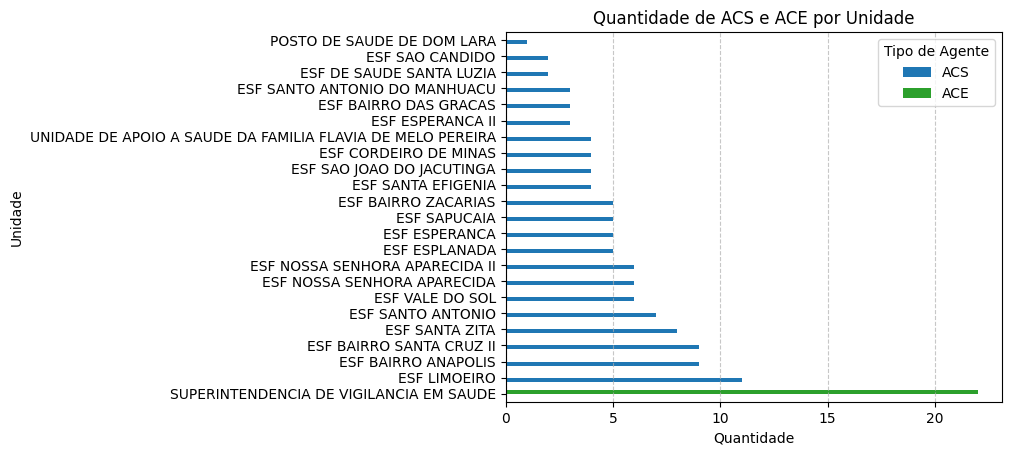

In [26]:
# Criando um gráfico de barras horizontal para visualizar a quantidade de ACS e ACE por unidade

colors = {'ACS': '#1f77b4', 'ACE': '#2ca02c'}


plt.figure(figsize=(10, 6))
df_agentes.sort_values("total", ascending=False).plot(kind='barh', x='unidade', y=['ACS', 'ACE'], color=colors)
plt.title('Quantidade de ACS e ACE por Unidade')
plt.xlabel('Quantidade')
plt.ylabel('Unidade')
plt.legend(title='Tipo de Agente', loc='upper right')
plt.yticks(rotation=0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Em alguns municípios, existe uma mistura maior de ACS e ACE por unidades.
# Essas informações são importantes para saber quantos profissionais vão receber uma capacitação por exemplo.

#### Encontrando a frequência dos CBOs e Visualizando os 10 mais frequentes

In [21]:
# Criando um DataFrame a partir da frequência de cada CBO no DataFrame original

cbo_freq = df_cnes["cbo"].value_counts().reset_index()

cbo_freq.rename(columns={'count': 'total'}, inplace=True)

display(cbo_freq)

,cbo,total
0,AGENTE COMUNITARIO DE SAUDE,112
1,TECNICO DE ENFERMAGEM,64
2,MEDICO CLINICO,42
3,VISITADOR SANITARIO,35
4,TECNICO DE ENFERMAGEM DA ESTRATEGIA DE SAUDE D...,35
...,...,...
75,MEDICO DO TRABALHO,1
76,CIRURGIAO DENTISTA ESTOMATOLOGISTA,1
77,CIRURGIAO DENTISTA ODONTOPEDIATRA,1
78,DIRETOR FINANCEIRO,1


In [22]:
# Armazenando os dados do DataFrame em um arquivo xlsx para ser visualizado mais tarde no Exel

cbo_freq.to_excel("cbo_freq.xlsx", index=False)

In [23]:
# Trazendo os 10 CBOs mais frequentes

top_10_cbo = cbo_freq.head(10)

display(top_10_cbo)

,cbo,total
0,AGENTE COMUNITARIO DE SAUDE,112
1,TECNICO DE ENFERMAGEM,64
2,MEDICO CLINICO,42
3,VISITADOR SANITARIO,35
4,TECNICO DE ENFERMAGEM DA ESTRATEGIA DE SAUDE D...,35
5,ENFERMEIRO,34
6,MEDICO DA ESTRATEGIA DE SAUDE DA FAMILIA,32
7,ENFERMEIRO DA ESTRATEGIA DE SAUDE DA FAMILIA,31
8,AGENTE DE COMBATE AS ENDEMIAS,22
9,ASSISTENTE ADMINISTRATIVO,20


<Figure size 1000x600 with 0 Axes>

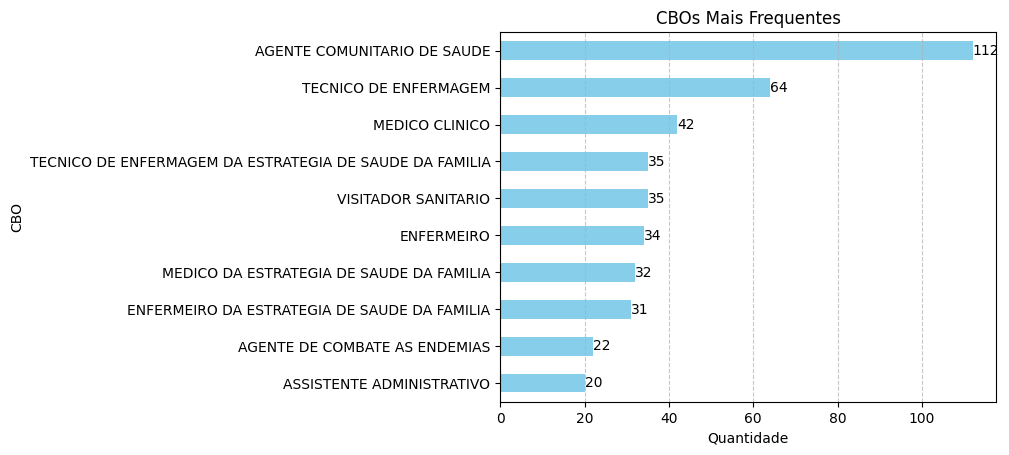

In [24]:
# Plotando um gráfico de barras horizontal para visualizaçãos dos CBOs mais frequentes

top_10_cbo_sorted = top_10_cbo.sort_values(by='total')

plt.figure(figsize=(10,6))
top_10_cbo_sorted.plot(kind="barh", x="cbo", color="skyblue")

for index, value in enumerate(top_10_cbo_sorted['total']):
    plt.text(value, index, str(value), ha='left', va='center')

plt.title("CBOs Mais Frequentes")
plt.xlabel("Quantidade")
plt.ylabel("CBO")
plt.legend().remove()
plt.grid(axis="x", linestyle='--', alpha=0.7)
plt.show()